<a href="https://colab.research.google.com/github/jsrobson/2023-cis5450-termproject/blob/main/CIS5450_TermProject_06_Expanded_Variable_Model_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook: Introducing confounding variables into the model

*Description:* This notebook builds upon the work performed in "[Modelling a bivariate relationship](https://colab.research.google.com/drive/12OA_Eyb08_l09aycU7XbvlIf-rWKsFW9?usp=sharing)" to continue exploration of the relationship between `cost_fl_area` (the average property cost per square metre in an LSOA geographic area) and an independent variable `count_list` (the number of short-term rental [STR] listings in a LSOA geographic area).

This is the second of three notebooks that apply a modelling approach to the data we have sourced, cleaned, and collated.

As before, we use Linear Regression modelling approaches due to the continuous nature of the variables explored. In this notebook, we introduce several **confounding variables** in the form of the scores for the domains established in the [English Indicies of Deprivation 2019](https://data.london.gov.uk/dataset/indices-of-deprivation), collected at the LSOA level for Greater London.

For more information on LSOA geographic areas, consult the [Compose Data](https://colab.research.google.com/drive/1utDtpkmgJnKhD5-8t7_jDoNIPnfgX4Mi?usp=sharing) notebook.

*Data:* As in the prior "Modelling a bivariate relationship" notebook, input data `lsoa_summaries` is used as input to this analysis workflow. This data is produced as the result of collation, cleaning, and compilation of other foundational datasets in the Compose Data notebook. The input data comprises 1,885 rows (summarized at a LSOA geographic unit from `listings` and `properties` data each comprising >= 50,000 rows). The following features are included in the dataset, with particular focus on the features suffixed with the word `_score`, as the English Indices of Deprivation.

```
LSOA11CD: Given LSOA code, 2011 boundaries
avg_str_price: The average price (by night) of a STR property within the LSOA
cost_fl_area: The average cost by floor area (m^2) of a property within the LSOA
count_prop: The count of properties within the LSOA boundary
count_list: The count of STR listings within the LSOA boundary
borough: The borough (local government authority) to which the LSOA is a part
imd_score: The index of multiple deprivation (cumulative) score, UK Index of Deprivation (ID)
income_score: The income deprivation score, UK ID
employ_score: The employment deprivation score, UK ID
educ_score: The education, skills and training score, UK ID
health_score: The health deprivation and disability score, UK ID
crime_score: The crime deprivation score, UK ID
house_score: The barriers to housing and services score, UK ID
env_score: The living environment score, UK ID
```

*Return:* We adopt three different modelling approaches to explore the expanded relationship between `cost_fl_area`, `count_list`, and the additional confounding variables. These focus on unsupervised learning (K-means clustering), supervised learning (different Linear Regression models), and a Deep Learning neural network approach in two forms.

#1. Initialization

*Description:* In this section, we install or import packages, mount the appropriate file data, and read from a constructed database into a working dataframe.

*Return:* Dataframe `df`, comprising LSOA summary data.

In [ ]:
# import necessary libraries
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Note:** We have deprecated this database component but have retained it for posterity. This function reads [Council Tax band data](https://data.london.gov.uk/dataset/council-tax-charges-bands-borough) for the identified boroughs into the Notebook environment for merging the `df` dataframe. However, the difference in geographic scale between the tax (borough) and other data (LSOA, or sub-borough) reduced the importance and practicality of the tax as a confounding variable within our study.

In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('/content/drive/MyDrive/CIS5450/Term_Project/data/db_model')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Query to retrieve all rows from the 'model' table
query = "SELECT * FROM model;"

# Execute the query and fetch the results
try:
    df = pd.read_sql_query(query, conn)
    print("Data successfully loaded into DataFrame.")
    # Display the DataFrame
except Exception as e:
    print("Error:", e)
finally:
    # Close the connection
    conn.close()

Data successfully loaded into DataFrame.


In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('/content/drive/MyDrive/CIS5450/Term_Project/data/db_model')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

query = "SELECT borough,average_tax_band FROM taxband;"

# Execute the query and fetch the results
try:
    tax_band = pd.read_sql_query(query, conn)
    print("Tax band Data successfully loaded into DataFrame.")
    # Display the DataFrame
except Exception as e:
    print("Error:", e)
finally:
    # Close the connection
    conn.close()

Tax band Data successfully loaded into DataFrame.


In [ ]:
# read lsoa data into a pandas dataframe
mainfilename = "/content/drive/MyDrive/CIS5450/Term_Project/data/lsoa_summaries.csv"
df = pd.read_csv(mainfilename)
#df = main_df.rename(columns={"room_type_Entire home/apt": "room_type_Entire", "room_type_Hotel room": "room_type_Hotel", "room_type_Private room": "room_type_Private", "room_type_Shared room": "room_type_Shared"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1885 non-null   int64  
 1   LSOA11CD       1885 non-null   object 
 2   avg_str_price  1885 non-null   float64
 3   cost_fl_area   1885 non-null   float64
 4   count_prop     1885 non-null   int64  
 5   count_list     1885 non-null   int64  
 6   borough        1885 non-null   object 
 7   imd_score      1885 non-null   float64
 8   income_score   1885 non-null   float64
 9   employ_score   1885 non-null   float64
 10  educ_score     1885 non-null   float64
 11  health_score   1885 non-null   float64
 12  crime_score    1885 non-null   float64
 13  house_score    1885 non-null   float64
 14  env_score      1885 non-null   float64
dtypes: float64(10), int64(3), object(2)
memory usage: 221.0+ KB


In [ ]:
# cell originally premised on merge, removed given explanation above, data set to df
#data = df.merge(tax_band, left_on=['borough'], right_on=['borough'], how = 'outer', indicator=True)
data = df

#null_val = data[data['_merge']!= 'both']
#null_val

# 2. Data cleaning and pre-processing

*Description:* In this section, we clean and pre-process the selected data in anticipation of our modelling tasks. We identify the model features and set target, engineer features, and conduct analysis of a correlation matrix to support optimal model behaviour.

*Data:* Dataframe `df`, comprising LSOA summary data.

*Return:* Dataframe `X_filtered`, a dataset derived from our starting data that has been engineered for modelling purposes.

To begin, we select model features and target.

In [ ]:
# Consider the overall shape of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1885 non-null   int64  
 1   LSOA11CD       1885 non-null   object 
 2   avg_str_price  1885 non-null   float64
 3   cost_fl_area   1885 non-null   float64
 4   count_prop     1885 non-null   int64  
 5   count_list     1885 non-null   int64  
 6   borough        1885 non-null   object 
 7   imd_score      1885 non-null   float64
 8   income_score   1885 non-null   float64
 9   employ_score   1885 non-null   float64
 10  educ_score     1885 non-null   float64
 11  health_score   1885 non-null   float64
 12  crime_score    1885 non-null   float64
 13  house_score    1885 non-null   float64
 14  env_score      1885 non-null   float64
dtypes: float64(10), int64(3), object(2)
memory usage: 221.0+ KB


In [ ]:
# drop features that will not be needed in the model
# legacy ID
model_df = data.drop(['Unnamed: 0'], axis=1)
# LSOA codename
model_df = model_df.drop(['LSOA11CD'], axis=1)
# employment score
model_df = model_df.drop(['employ_score'], axis=1)
# print head to confirm feature drops
model_df.head()

,avg_str_price,cost_fl_area,count_prop,count_list,borough,imd_score,income_score,educ_score,health_score,crime_score,house_score,env_score
0,137.90,13261.97,40,10,City of London,6.2,0.0,0.0,-1.7,-2.0,29.5,31.9
1,180.87,14235.39,27,15,City of London,5.1,0.0,0.1,-1.1,-2.3,24.4,23.1
2,81.07,13600.62,99,14,City of London,19.4,0.1,5.8,-0.1,-1.0,40.1,40.5
3,128.67,8998.64,7,64,City of London,28.7,0.2,22.3,-0.1,-1.3,39.9,29.0
4,124.82,11701.46,24,34,Camden,8.5,0.1,5.4,-1.5,0.0,20.7,28.6


**Feature engineering:** We now perform one-hot encoding on categorical values within the dataset. This will be focused solely on the `borough` feature column.

In [ ]:
# identify categorical columns
categorical_cols = ['borough']
# conduct one-hot encode borough
main_df = pd.get_dummies(model_df, columns=categorical_cols)
# print head to confirm operation worked as expected
main_df.head(5)

,avg_str_price,cost_fl_area,count_prop,count_list,imd_score,income_score,educ_score,health_score,crime_score,house_score,...,borough_Hammersmith and Fulham,borough_Islington,borough_Kensington and Chelsea,borough_Lambeth,borough_Lewisham,borough_Newham,borough_Southwark,borough_Tower Hamlets,borough_Wandsworth,borough_Westminster
0,137.90,13261.97,40,10,6.2,0.0,0.0,-1.7,-2.0,29.5,...,0,0,0,0,0,0,0,0,0,0
1,180.87,14235.39,27,15,5.1,0.0,0.1,-1.1,-2.3,24.4,...,0,0,0,0,0,0,0,0,0,0
2,81.07,13600.62,99,14,19.4,0.1,5.8,-0.1,-1.0,40.1,...,0,0,0,0,0,0,0,0,0,0
3,128.67,8998.64,7,64,28.7,0.2,22.3,-0.1,-1.3,39.9,...,0,0,0,0,0,0,0,0,0,0
4,124.82,11701.46,24,34,8.5,0.1,5.4,-1.5,0.0,20.7,...,0,0,0,0,0,0,0,0,0,0


**Corellation matrix:** We now deploy a correlation matrix to determine if there are any correlations among the features that may unduly influence model behaviour.

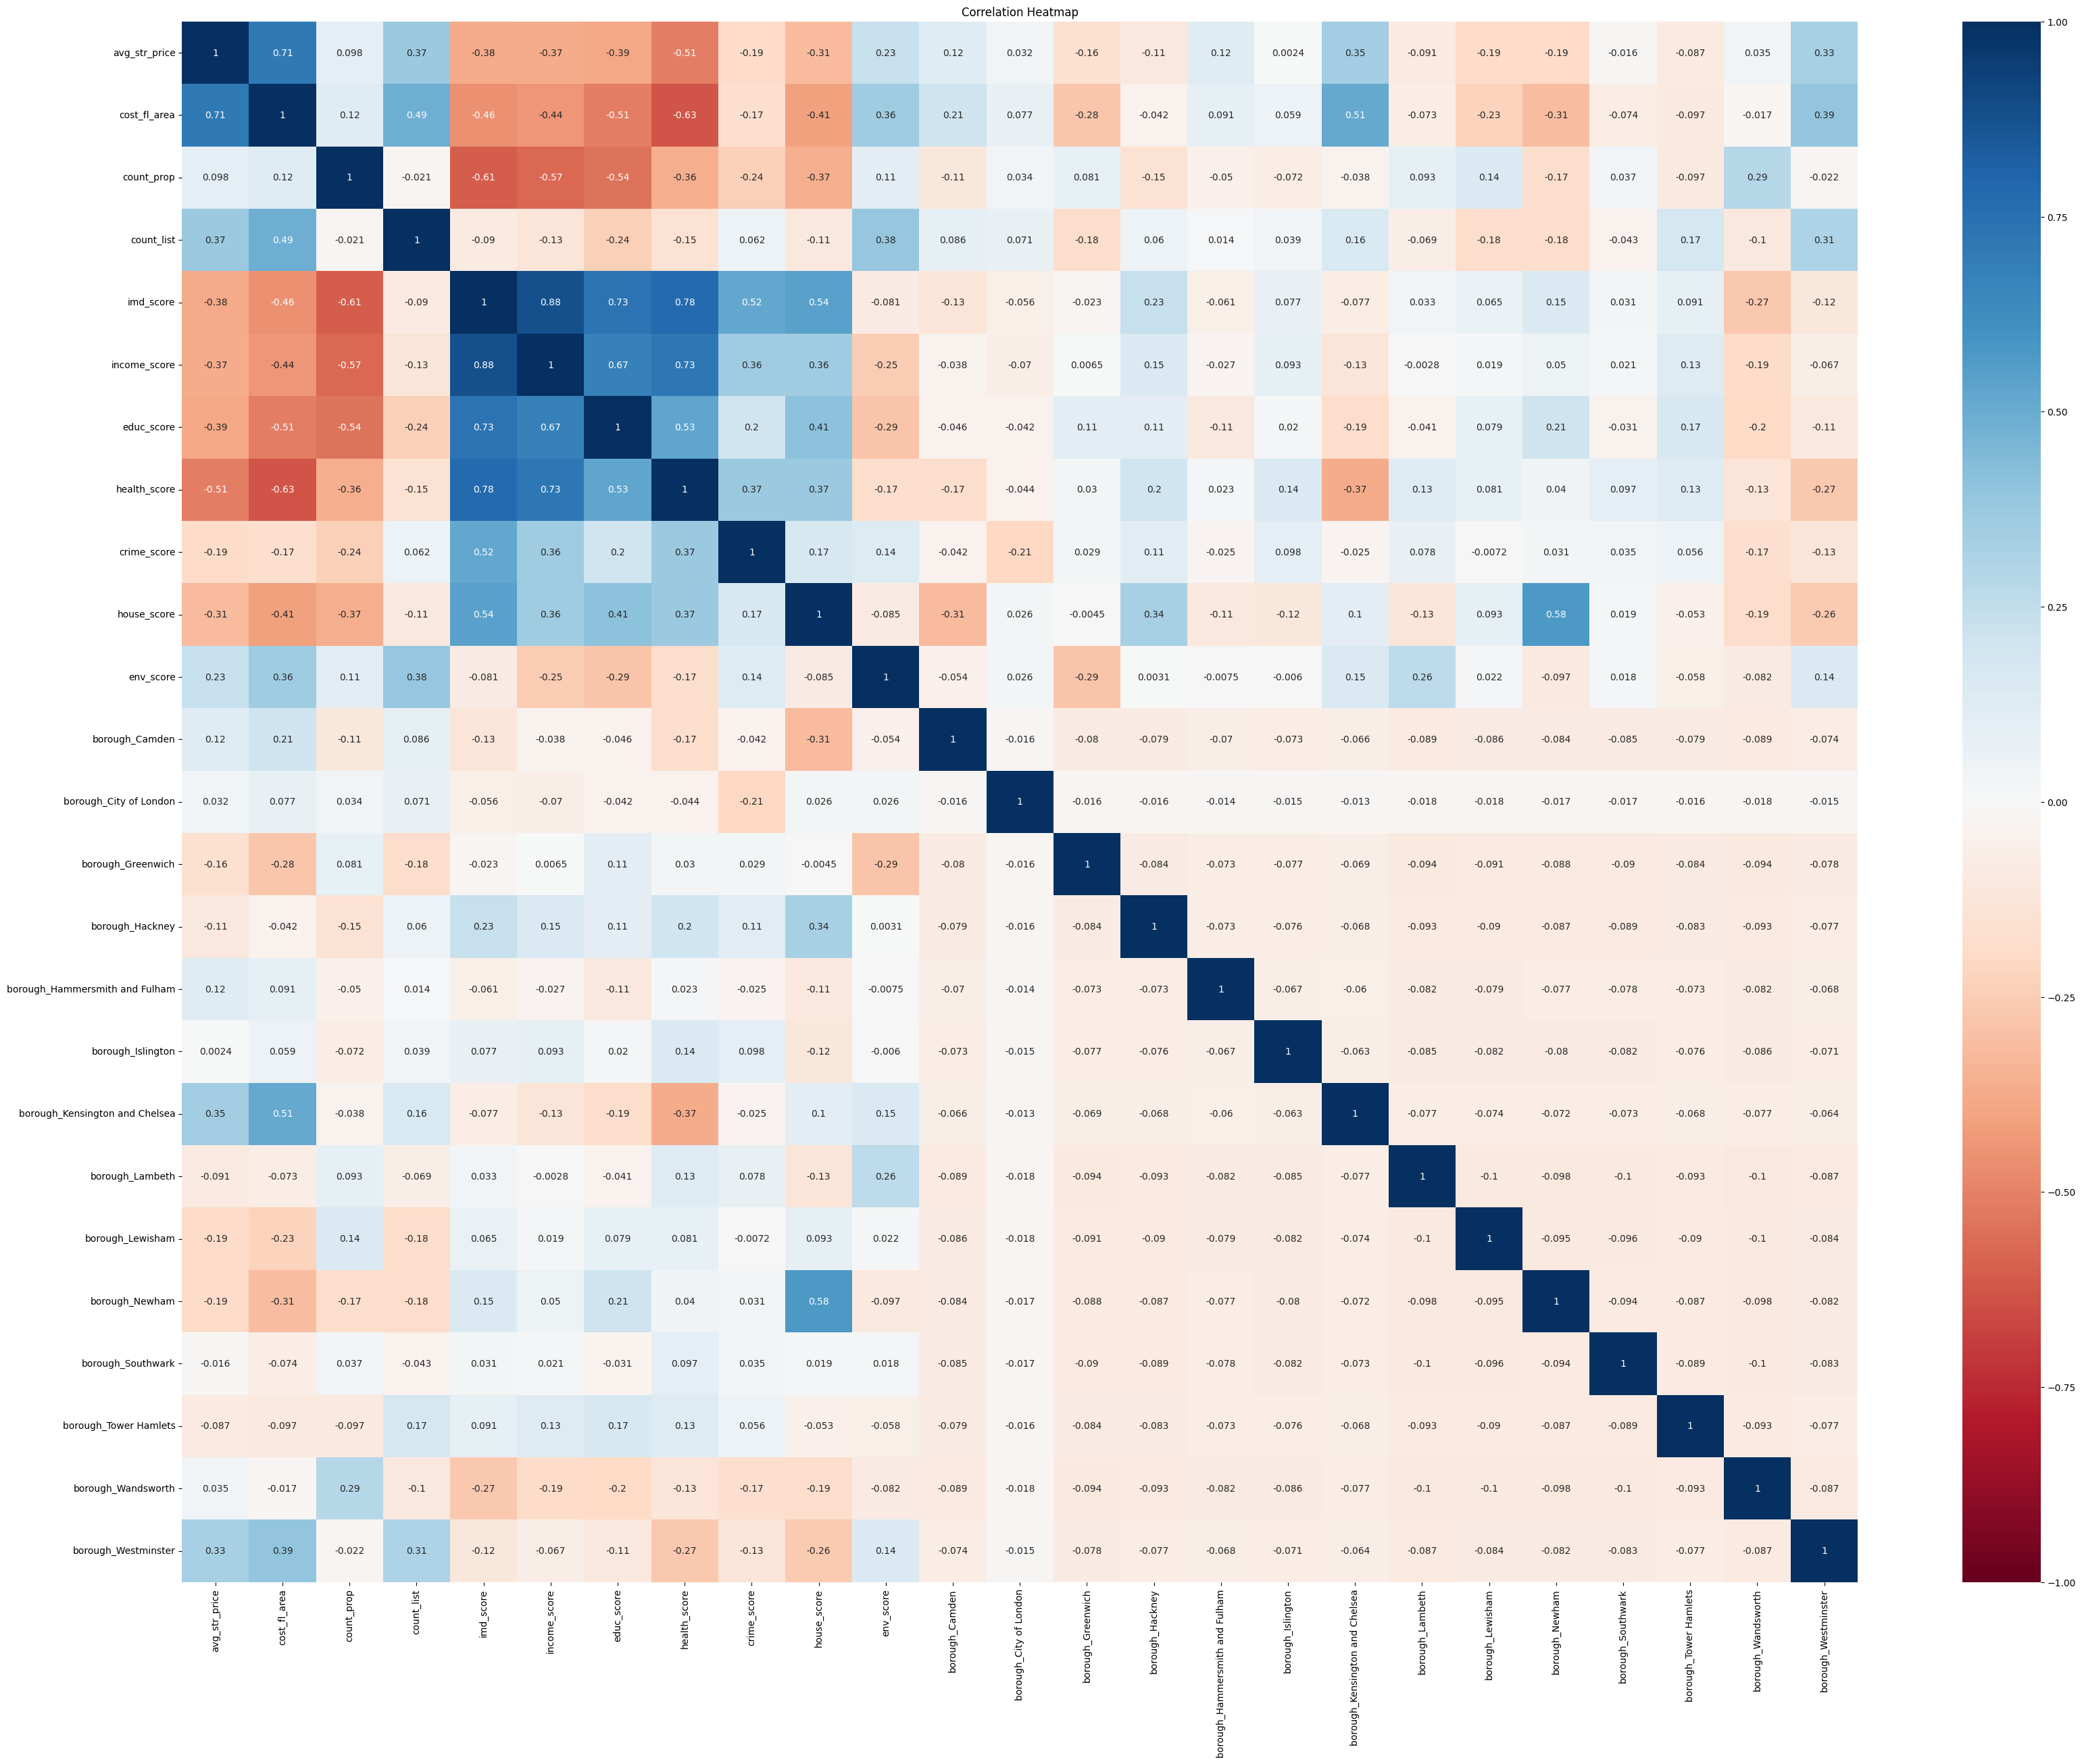

In [ ]:
correlation_matrix = main_df.corr()
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmax=1,vmin = -1)
plt.title('Correlation Heatmap')
plt.show()

As we might expect, the `imd_score` (Indices of Multiple Deprivation Score) exhibits a high correlation with other domain-based indices of deprivation. This is unsurprising as the `imd_score` is a cumulative composite of the domain-based scores. Thus, we drop this feature.

In [ ]:
# drop correlative IMD score
X_filtered = main_df.drop(['imd_score'], axis=1)
# print resulting columns to confirm
X_filtered.columns

Index(['avg_str_price', 'cost_fl_area', 'count_prop', 'count_list',
       'income_score', 'educ_score', 'health_score', 'crime_score',
       'house_score', 'env_score', 'borough_Camden', 'borough_City of London',
       'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Islington',
       'borough_Kensington and Chelsea', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Newham', 'borough_Southwark', 'borough_Tower Hamlets',
       'borough_Wandsworth', 'borough_Westminster'],
      dtype='object')

#3. Unsupervised Learning

*Description:* In this section, we aim to discover any extant hidden patterns in the passed data and will deploy an array of unsupervised learning techniques to assist us to this end.

*Data:* Dataframe `X_filtered`, a dataset derived from our starting data that has been engineered for modelling purposes.

We will apply Principal Component Analysis (PCA) to explore the features that maximize the variance in our dataset. We then make predictions and apply clustering algorithms to a reduced dataset.


### Split data to test and train datasets

In [ ]:
# generate our preliminary feature set
features = X_filtered.copy()

# instantiate target as dependent variable cost_fl_area
target = features['cost_fl_area'].astype(int)
# drop cost_fl_area from our feature set
features = features.drop(['cost_fl_area'], axis=1)

# split data into test / train sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

##Conduct Principal Component Analysis

**Initial Principal Component Analysis (PCA):**

As a first step, we will try to find what is the ideal number of principal components to choose. Since PCA is not scale-invariant, we first need to standardize the features using a [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class.

PCA will be useful in attending to the existence of multi-colinearity between variables (features).

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# initialize scaler object
scaller = StandardScaler()
# scale training data
X_trained  = scaller.fit_transform(X_train)
# instantiate a PCA object
pca = PCA()
# apply PCA to scaled training data
X_trained_pca = pca.fit_transform(X_trained)

**Cumulative Explained Variance Ratios:**

This step illustrates the accumulated variance represented by *n* as the number of principal components. This will assist us to reduce the dimensionality of the dataset while retaining as much salient information as is possible.

We plot the cumulative explained variance ratio against the number of principal components to help decide the number of components that will retain 95 per cent of the variance in the data while reducing its overall dimensionality.

In [ ]:
# generate explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# generate CUMULATIVE explained variance ratios
cum_evr = np.cumsum(pca.explained_variance_ratio_)

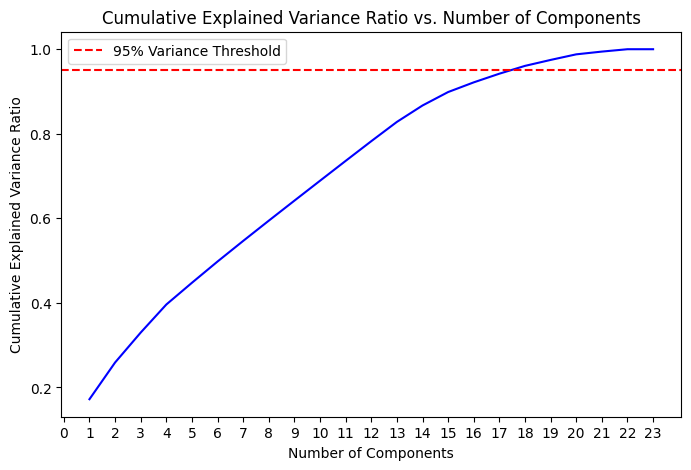

In [ ]:
# generate plot to find optimal num components to use
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_evr)+1 ), cum_evr, color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.legend()
plt.xticks(np.arange(len(cum_evr)+1))
plt.show()

In [ ]:
# How many components do we need to explain 95% of the variance?
cum = np.cumsum(explained_variance_ratios)
np.where(cum > 0.98)[0][0]

19

**Final PCA**:

From the above exploration, we observe that 19 principal components explain at least 95% of the total variance in the dataset. Now, we re-fit and transform the PCA object on the training set.

PCA will be trained on the training set (`X_train`) but only transformed on the test set (`X_test`).

In [ ]:
# instantiate new PCA object given exploration
pca_19 = PCA(n_components=19)

# refit and transform on training data
X_train_pca = pca_19.fit_transform(X_trained)

# transform on testing Set
X = scaller.transform(X_test)
X_test_pca = pca_19.transform(X)

We will now conduct a linear regression on the dataset to evaluate performance on a preliminary basis.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# Linear Regression model object
clf = LinearRegression()

# Fit the model using the principal components of the training data
clf.fit(X_train_pca, y_train)

# predictions on the test data using the trained model
predictions = clf.predict(X_test_pca)

# Calculate and print different error measures for model evaluation
print("R-squared score:", clf.score(X_test_pca, y_test))
print("Mean Absolute Error:", mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))

R-squared score: 0.8521063051223144
Mean Absolute Error: 878.6546156321547
Mean Squared Error: 1634649.609346186
Root Mean Squared Error: 1278.5341643249844


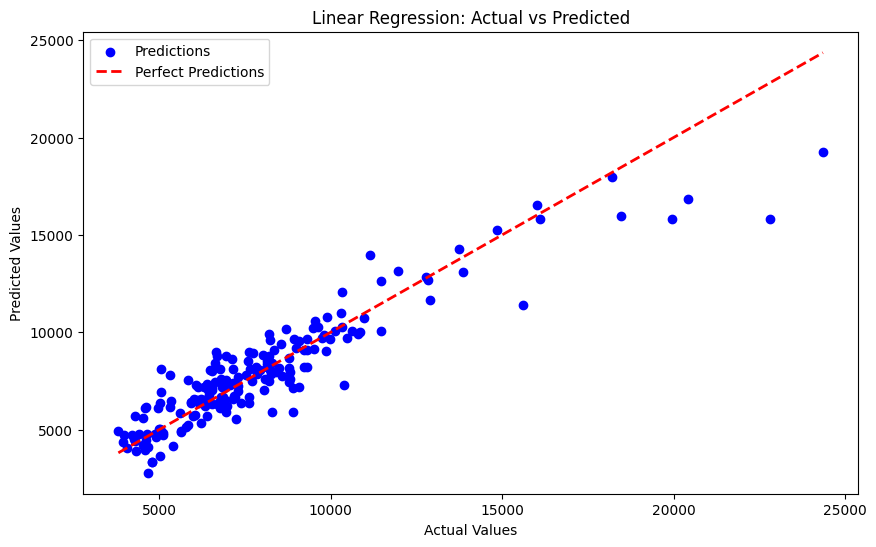

In [ ]:
# Plot the prediction curve
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

**Result:** The R-square score suggests that the model explains approximately 85 per cent of dependent variable variation, which offers sufficient performance. With respect to the Root Mean Squared Error (RMSE), suggesting an average error of 1,278.53 per prediction, which is performing well in the context of prior explorations.

## K-Means Clustering

We now consider the possible groupings (clusters) present in our dataset. We will visualize a graphical 'elbow' plot to help us choose the number of clusters that minimize the Within-Cluster Sum of Square (WCSS) while avoiding over-fitting the model.

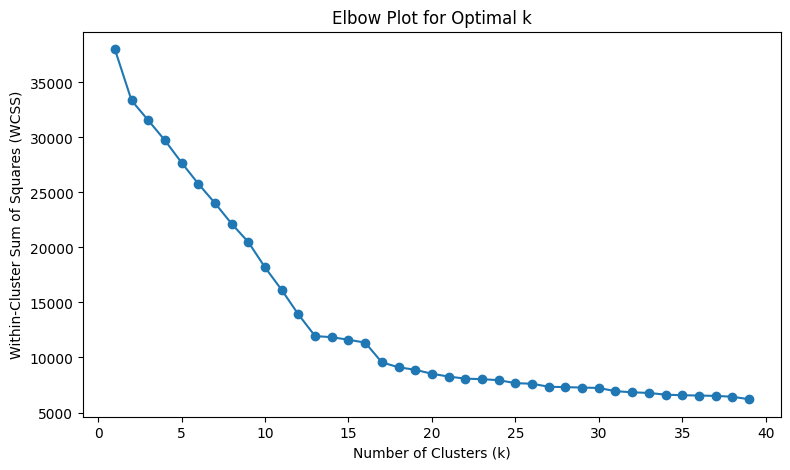

In [ ]:
from sklearn.cluster import KMeans

# for k ranges from 1 to 40, fit on "features" to generate an elbow plot
distortions = []
for i in range(1,40):
  km = KMeans(n_clusters=i,init = 'random', n_init = 1, max_iter = 500, random_state=0)
  km.fit(X_train_pca)
  # The distortion is called inertia in SciKit
  distortions.append(km.inertia_)


plt.figure(figsize=(9,5))
plt.plot(range(1,40), distortions, marker='o')
plt.title('Elbow Plot for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

**Cluster formed by principal components:** We observe that an "elbow" forms in the visualized plot around a *k* value of 23. We set *k = 23* as the number of clusters and fit on the result of our reduced training set.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


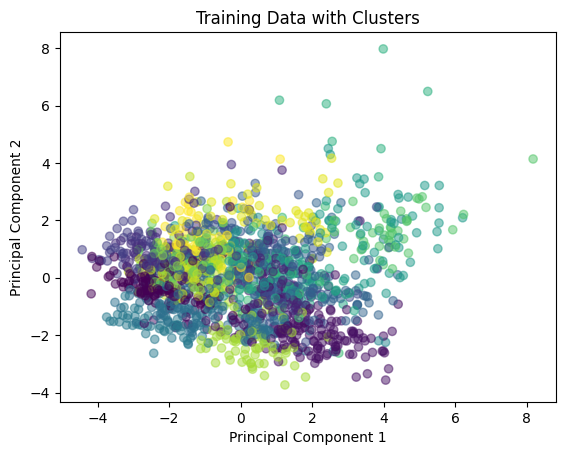

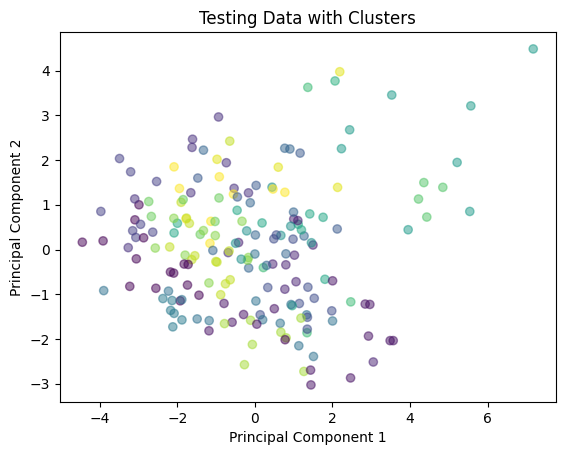

In [ ]:
# number of clusters
num_clusters = 23

# Fit KMeans model on training data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train_pca)

# Visualize the clusters on the training set
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=X_train['cluster'], cmap='viridis', marker='o', alpha=0.5)
plt.title('Training Data with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Apply the same clusters to the testing set
X_test['cluster'] = kmeans.predict(X_test_pca)

# Visualize the clusters on the testing set
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=X_test['cluster'], cmap='viridis', marker='o', alpha=0.5)
plt.title('Testing Data with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Using two-dimensional visualization, we cannot clearly observe the extant clusters in our dataset; indeed, there appears to be only one clustering of data! We will apply a three-dimensional visualization to see if we can better identify the appearance of clusters in our dataset.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


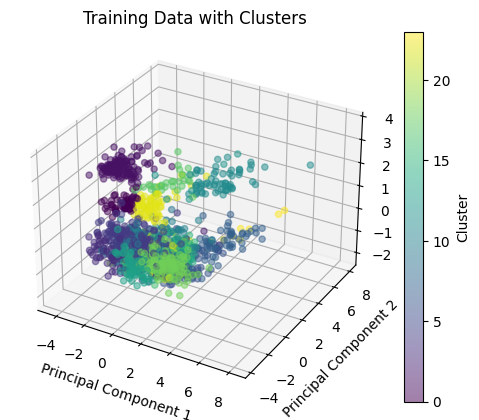

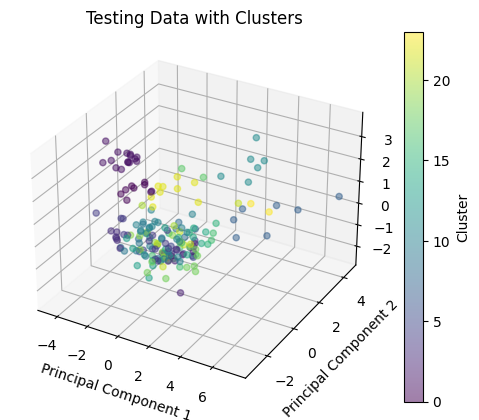

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

num_clusters = 24

# Fit KMeans model on training data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train_pca)

# Visualize the clusters on the training set in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=X_train['cluster'], cmap='viridis', marker='o', alpha=0.5)
ax.set_title('Training Data with Clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

# Apply the same clusters to the testing set
X_test['cluster'] = kmeans.predict(X_test_pca)

# Visualize the clusters on the testing set in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=X_test['cluster'], cmap='viridis', marker='o', alpha=0.5)
ax.set_title('Testing Data with Clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

We now see the formation of some clustering. We will now represent the average values of features within each cluster and see what features emerge as the most important.

In [ ]:
# get the means of each cluster and print
cluster_means = X_train.groupby('cluster').mean()
print(cluster_means)

         avg_str_price  count_prop  count_list  income_score  educ_score  \
cluster                                                                    
0            73.540500   13.433333   23.933333      0.245000   23.298333   
1            65.941608   20.748252   13.258741      0.167832   17.730070   
2            99.342258   44.387097   30.279570      0.105376    6.323656   
3            58.096897   22.310345    8.310345      0.225862   23.184483   
4            66.251242   37.875817   14.104575      0.161438   14.225490   
5           114.713273   25.772727   40.990909      0.185455   12.528182   
6           162.201918   29.082192   41.561644      0.078082    5.349315   
7           262.988621   38.172414   83.965517      0.056897    5.248276   
8            79.611928   16.506024   45.518072      0.242169   22.849398   
9            92.526818   25.659091   21.750000      0.186364   13.495455   
10          107.377338   32.000000   30.899281      0.161871   11.030935   
11          

We now consider which features are the most important in each cluster ... and, by a runaway margin, it is `avg_str_price`. That is, this feature significantly influences the clustering result as we have organized the data.

In [ ]:
abs_mean_values = cluster_means.abs()
most_important_features = abs_mean_values.idxmax(axis=1)
print(most_important_features)

cluster
0     avg_str_price
1     avg_str_price
2     avg_str_price
3     avg_str_price
4     avg_str_price
5     avg_str_price
6     avg_str_price
7     avg_str_price
8     avg_str_price
9     avg_str_price
10    avg_str_price
11    avg_str_price
12    avg_str_price
13    avg_str_price
14    avg_str_price
15    avg_str_price
16    avg_str_price
17    avg_str_price
18    avg_str_price
19    avg_str_price
20    avg_str_price
21    avg_str_price
22    avg_str_price
23       count_list
dtype: object


#4. Supervised Learning
*Description:* In this section, we will use our dataset to predict outcomes using a variety of supervised learning models. Our approach will employ several different flavours of linear regression model to forecast and subsequently compare their performance. As before, our focus will be on the prediction of `cost_fl_area` for short-term rental (STR) listings within each borough.

*Data:* Dataframe `X_filtered`, a dataset derived from our starting data that has been engineered for modelling purposes.

*Return:* Model outputs for standard [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [Lasso (L1 Regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [Ridge Regression (L2 regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), and [ElasticNet (L1/L2 regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).


### Split data to test and train datasets

For our regression model, we've chosen to allocate only 10 per cent of the data to the test set. Extensive parameter tuning has revealed that this allocation provides the optimal amount of data for training the model and achieving better predictions.

Initially, with splits like 80-20 or 70-30, the model exhibited a phenomenon where it performed well on certain `y` values but poorly on others.

Given the limited number of rows in the dataset, a 90 per cent training set allows the model to be exposed to a broader range of scenarios. While other methods-such as cross-validation-may be beneficial, our approach prioritizes maximizing training scenarios with the available data.



In [ ]:
# generate features
features = X_filtered.copy()
# get target - dependent variable, cost_fl_area
target = features['cost_fl_area'].astype(int)
# get features – independent variables, all but cost_fl_area
features = features.drop(['cost_fl_area'], axis=1)

# split into test/train datasets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1)

In [ ]:
# observe composition of training dataset
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 779 to 1469
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   avg_str_price                   1696 non-null   float64
 1   count_prop                      1696 non-null   int64  
 2   count_list                      1696 non-null   int64  
 3   income_score                    1696 non-null   float64
 4   educ_score                      1696 non-null   float64
 5   health_score                    1696 non-null   float64
 6   crime_score                     1696 non-null   float64
 7   house_score                     1696 non-null   float64
 8   env_score                       1696 non-null   float64
 9   borough_Camden                  1696 non-null   uint8  
 10  borough_City of London          1696 non-null   uint8  
 11  borough_Greenwich               1696 non-null   uint8  
 12  borough_Hackney                 

### Standard linear regression

In this initial model, we use a standard [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model to predict the `cost_fl_area` for str listings.

We also perform the following evaluations on the model:

* **Root Mean Squared Error (RMSE):** This metric, measuring the average magnitude of errors between predicted and actual values, is a critical evaluation parameter. The RMSE provides a holistic understanding of the model's prediction accuracy.

* **Mean Squared Error (MSE):** Complementing the RMSE, the MSE measures the average squared differences between predicted and actual values. A lower MSE indicates superior model performance.

* **Mean Absolute Error (MAE):** The MAE calculates the average absolute differences between predicted and actual values. This metric provides a straightforward understanding of prediction accuracy.

* **Explained Variance Score (R-squared score):** This score, ranging from 0 to 1, indicates the proportion of variance in the dependent variable that is predictable from the independent variables. An R-squared score closer to 1 implies a better fit.

While our initial Linear Regression model provides valuable insights, exploring alternative models is essential for a comprehensive analysis. We will consider the alternative Linear Regression 'flavours' of [Lasso (L1 Regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [Ridge Regression (L2 regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), and [ElasticNet (L1/L2 regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).

Other models-or even advanced techniques like Neural Networks-may offer improved predictive capabilities. These alternatives could capture non-linear relationships or interactions within the data, potentially enhancing our ability to forecast `cost_fl_area` accurately.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score

# instantiate linear regression model
linear_reg_model = LinearRegression()

# fit on train data
linear_reg_model.fit(X_train, y_train)

#Use the model to predict on the test set
prediction = linear_reg_model.predict(X_test)

# Root Mean Squared Error (RMSE)
linear_reg_rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("Linear Regression Root Mean Squared Error (RMSE):", linear_reg_rmse)

# Calculate Mean Squared Error (MSE)
linear_reg_mse = mean_squared_error(y_test, prediction)
print("Linear Regression Mean Squared Error (MSE):", linear_reg_mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, prediction)
print("Linear Regression Mean Absolute Error (MAE):", mae)

# Calculate R-squared score:
print("Linear Regression R-squared score:", linear_reg_model.score(X_test, y_test))

Linear Regression Root Mean Squared Error (RMSE): 1160.336081257258
Linear Regression Mean Squared Error (MSE): 1346379.82146745
Linear Regression Mean Absolute Error (MAE): 850.6396730462919
Linear Regression R-squared score: 0.8546403567362773


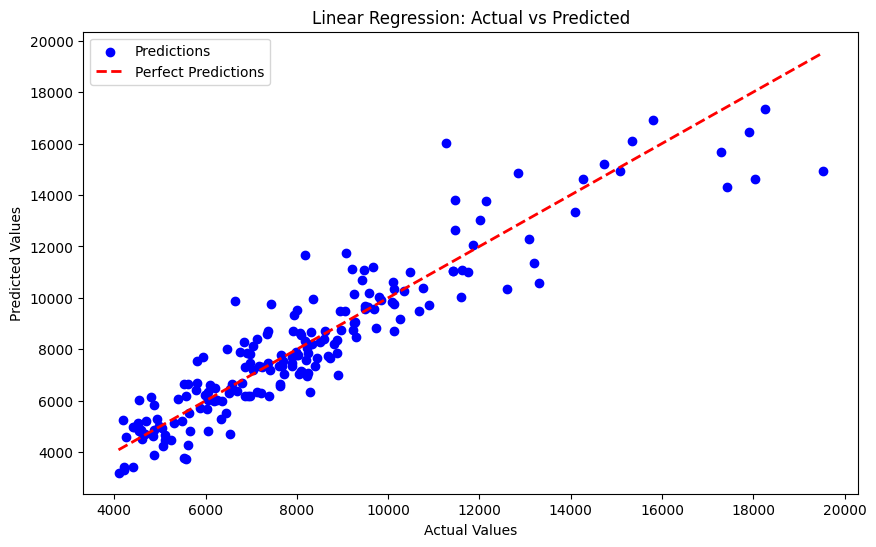

In [ ]:
# Plot the prediction curve
plt.figure(figsize=(10, 6))
plt.scatter(y_test, prediction, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

**Result:** As before, R-square score suggests that the model explains approximately 85 per cent of dependent variable variation, which offers sufficient performance.

With respect to the Root Mean Squared Error (RMSE), suggesting an average error of 1,160.29 per prediction, which is performing well in the context of prior explorations.

### Lasso Regression (L1 regularization)

We now consider **Lasso Regression (L1 regularization)** to reduce the possibility of overfitting and improve model generalization.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# instantiate scaler model and scale train, test data
scal = StandardScaler()
X_scalled = scal.fit_transform(X_train)
X_test_scalled = scal.transform(X_test)

# Initialize Lasso model
reg_lasso = Lasso(alpha=0.1, max_iter=10000).fit(X_scalled, y_train)

# Use the Lasso model to predict on the test set
y_pred_lasso = reg_lasso.predict(X_test_scalled)

# Root Mean Squared Error (RMSE)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print("Lasso Regression Root Mean Squared Error (RMSE):", lasso_rmse)

# Calculate Mean Squared Error (MSE)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print("Lasso Regression Mean Squared Error (MSE):", lasso_mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_lasso)
print("Lasso Regression Mean Absolute Error (MAE):", mae)

# Find the R-squared score
lasso_score = reg_lasso.score(X_test_scalled, y_test)
print("Lasso Regression R-squared:", lasso_score)


Lasso Regression Root Mean Squared Error (RMSE): 1160.286086927228
Lasso Regression Mean Squared Error (MSE): 1346263.8035168992
Lasso Regression Mean Absolute Error (MAE): 850.5943115275155
Lasso Regression R-squared: 0.8546528824200668


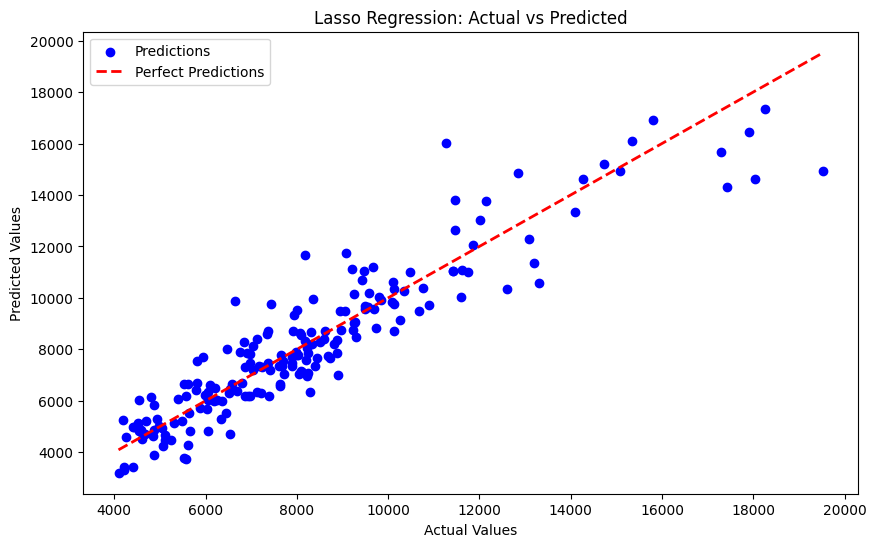

In [ ]:
# Plot the prediction curve
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.title('Lasso Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


**Result:** We do not observe any marked divergence from the standard Linear Regression output. The models perform with general equivalence.

### Ridge Regression (L2 regularization)

We now consider **Ridge Regression (L2 regularization)** to attend to any extant multicolinearity in the data. While we believe we have controlled for this through analysis and action stemming from the correlation matrix, we deploy this model in the event that our hand-tuned approach was not comprehensive.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# instantiate scaler model and scale train, test data
scal = StandardScaler()
X_scalled  = scal.fit_transform(X_train)
X_test_scalled  = scal.transform(X_test)

# instantiate ridge regression model
reg_ridge = Ridge(alpha=10).fit(X_scalled, y_train)

# generate predictions
y_pred_ridge = reg_ridge.predict(X_test_scalled)

# Root Mean Squared Error (RMSE)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print("Ridge Regression Root Mean Squared Error (RMSE):", ridge_rmse)

# Calculate Mean Squared Error (MSE)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print("Ridge Regression Mean Squared Error (MSE):", ridge_mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_ridge)
print("Ridge Regression Mean Absolute Error (MAE):", mae)

# Find the R-squared score
lasso_score = reg_ridge.score(X_test_scalled, y_test)
print("Ridge Regression R-squared:", lasso_score)

Ridge Regression Root Mean Squared Error (RMSE): 1160.3133174729446
Ridge Regression Mean Squared Error (MSE): 1346326.9947050705
Ridge Regression Mean Absolute Error (MAE): 850.0886396322039
Ridge Regression R-squared: 0.8546460600892329


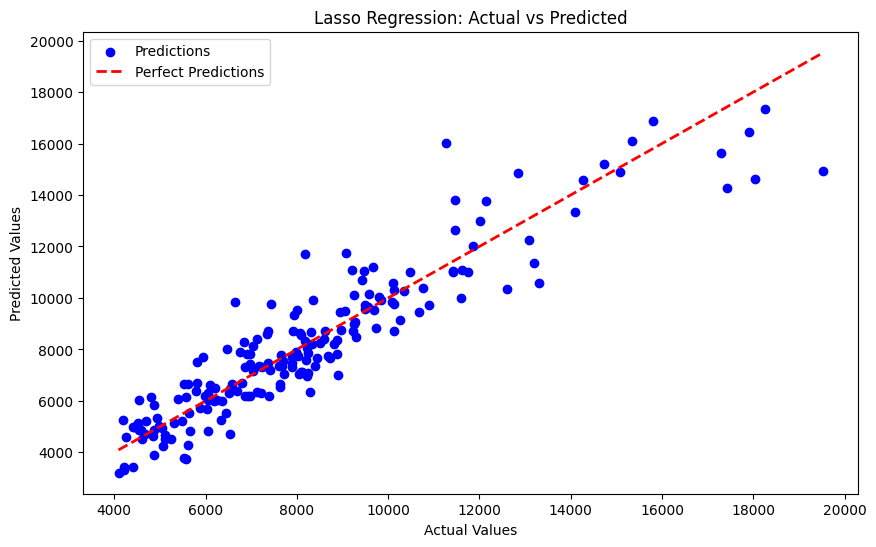

In [ ]:
# Plot the prediction curve
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.title('Ridge Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

**Result:** We do not observe any marked divergence from the standard Linear Regression output. The models perform with general equivalence.

### ElasticNet (L1/L2 regularization)

We now consider as our final supervised learning model Elastic Net Regression, a combination of Lasso and Ridge Regression. This allows us to benefit from a blend of both L1 and L2 regularization. We posit that this will not have a significant effect on model perform given the consistency across our models to this point.

In [ ]:
from sklearn.linear_model import ElasticNet

# Initialize ElasticNet model with alpha = 0.1 and l1_ratio = 0.5
reg_elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5).fit(X_scalled, y_train)

# predict on the test set
y_pred_elastic_net = reg_elastic_net.predict(X_test_scalled)

# Find the R-squared score
elastic_net_score = reg_elastic_net.score(X_test_scalled, y_test)
print("Elastic Net Regression R-squared:", elastic_net_score)

# Compute Mean Squared Error (MSE) for Elastic Net regression
elastic_net_mse = mean_squared_error(y_test, y_pred_elastic_net)
print("Elastic Net Regression MSE:", elastic_net_mse)

# Compute Root Mean Squared Error (RMSE) for Elastic Net regression
elastic_net_rmse = np.sqrt(elastic_net_mse)
print("Elastic Net Regression RMSE:", elastic_net_rmse)


Elastic Net Regression R-squared: 0.8544456976301722
Elastic Net Regression MSE: 1348182.8328579592
Elastic Net Regression RMSE: 1161.1127563066213


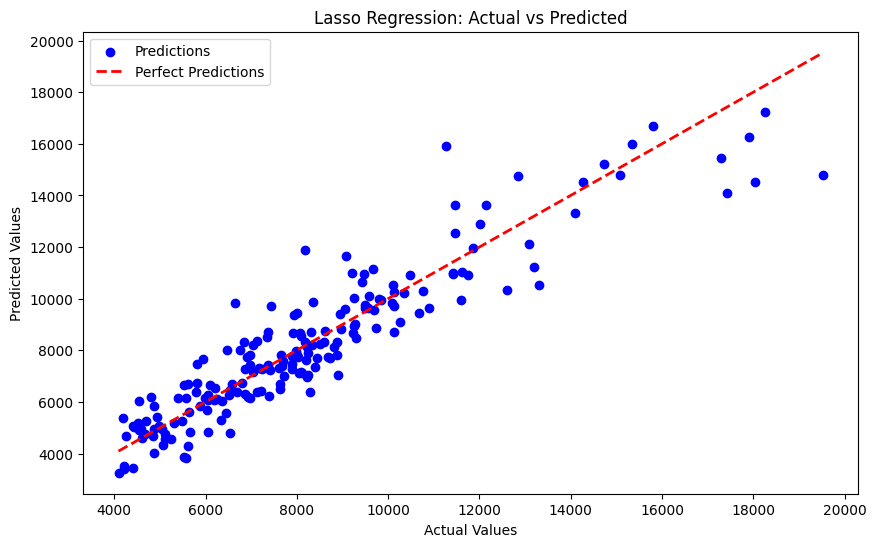

In [ ]:
# Plot the prediction curve
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_elastic_net, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.title('Elastic Net Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

**Result:** We do not observe any marked divergence from the standard Linear Regression output. The models perform with general equivalence as we posited.

**Interim conclusion:** To this point, the models so far have very similar performance metrics, with only slight variations in the evaluation scores. The R-squared scores for all models are around 0.85, indicating a good fit to the data. The RMSE values are also quite close, suggesting similar predictive performance.

The choice between these models may depend on other considerations, such as interpretability or the need for feature selection.

#5. Deep Learning

*Description:* Let's explore the potential performance gains by incorporating a variety of deep learning techniques using [PyTorch](https://pytorch.org/) and neural network (NN) architecture.

In this section, we will build two neural network architectures (one with, and one without **dropout**). We note given the functionality of the models to this point that this serves largely as an experimental exploration-we have the opportunity, so why not take advantage of it. As there are no complex interactions between features in our dataset, we posit that the straight-forward models explored previously are sufficient for our purposes.

*Data:* Dataframe `X_filtered`, a dataset derived from our starting data that has been engineered for modelling purposes.

*Return*: Model output from two Pytorch-driven neural network models.

### NN Architecture (with dropout to prevent overfitting)

The concept of **dropout** helps mitigate model overfitting by randomly "dropping out" (setting to zero) a proportion of neurons during each training iteration. This prevents any single neuron from relying too much on specific features in the training data, making the network more robust and generalizable.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# convert to numpy
X_train_default = np.array(X_train)
X_test_default = np.array(X_test)

# Initialize StandardScaler
s_scaler = StandardScaler()

# Scale train and test data sets using standard scaler
X_train_default = s_scaler.fit_transform(X_train_default)
X_test_default = s_scaler.transform(X_test_default)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train_default).float()
y_train_tensor = torch.Tensor(y_train).view(-1, 1).float()

X_test_tensor = torch.Tensor(X_test_default).float()


# neural network architecture
class MLPRegressorModel(nn.Module):
    def __init__(self, input_size):
        super(MLPRegressorModel, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(0.1)  # Add dropout with a probability of 0.5
        self.layer2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.layer3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        #x = self.dropout3(x)
        output = self.output_layer(x)
        return output

# Instantiate the model
input_size = X_train_default.shape[1]
model = MLPRegressorModel(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training the model
num_epochs = 200

for epoch in range(num_epochs):
    inputs = Variable(X_train_tensor)
    labels = Variable(y_train_tensor)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

with torch.no_grad():
    model.eval()
    test_inputs = Variable(X_test_tensor)
    predictions = model(test_inputs)

    # Convert predictions and labels to numpy arrays
    predictions_np = predictions.numpy()
    y_test_np = y_test.values

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_np, predictions_np)
    mse = mean_squared_error(y_test_np, predictions_np)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_np, predictions_np)

    print('Mean Absolute Error (MAE): {:.4f}'.format(mae))
    print('Mean Squared Error (MSE): {:.4f}'.format(mse))
    print('Root Mean Squared Error (RMSE): {:.4f}'.format(rmse))
    print('R-squared Score: {:.4f}'.format(r2))


Epoch [100/200], Loss: 2741536.5000
Epoch [200/200], Loss: 2632704.0000
Mean Absolute Error (MAE): 782.3421
Mean Squared Error (MSE): 1181324.7901
Root Mean Squared Error (RMSE): 1086.8877
R-squared Score: 0.8725


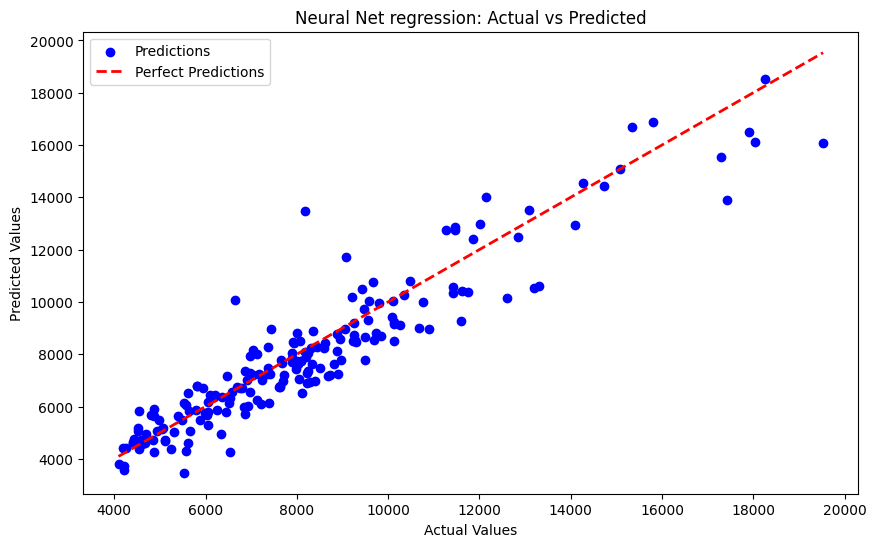

In [ ]:
# Plot the prediction curve
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, predictions_np, color='blue', label='Predictions')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.title('Neural Net regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

**Result:** We observe slight improvement on the NN performance over that of the prior slate of supervised learning models. In each category, the NN model sees minor performance gains.

```
Performance of ElasticNet(L1/L2 regularization):
Ridge Regression Root Mean Squared Error (RMSE): 1160.3133174729446
Ridge Regression Mean Squared Error (MSE): 1346326.9947050705
Ridge Regression Mean Absolute Error (MAE): 850.0886396322039
Ridge Regression R-squared: 0.8546460600892329
```



### NN Architecture (without dropout to prevent overfitting)

We now consider the development of NN architecture without **dropout**. That is, we explore the difference between the two architectures to determine if dropout is a determinant of model performance in the context of our dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X_train and X_test are NumPy arrays
X_train_default = np.array(X_train)
X_test_default = np.array(X_test)

# Initialize StandardScaler
s_scaler = StandardScaler()

# Scale train and test data sets using standard scaler
X_train_default = s_scaler.fit_transform(X_train_default)
X_test_default = s_scaler.transform(X_test_default)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train_default).float()
y_train_tensor = torch.Tensor(y_train).view(-1, 1).float()

X_test_tensor = torch.Tensor(X_test_default).float()
# Note: You don't need y_test for training in PyTorch

# Define a simple neural network model
class MLPRegressorModel(nn.Module):
    def __init__(self, input_size):
        super(MLPRegressorModel, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(input_size, 150)
        self.layer2 = nn.Linear(150, 100)
        self.layer3 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        output = self.output_layer(x)
        return output

# Instantiate the model
input_size = X_train_default.shape[1]
model = MLPRegressorModel(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
num_epochs = 200

for epoch in range(num_epochs):
    inputs = Variable(X_train_tensor)
    labels = Variable(y_train_tensor)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

with torch.no_grad():
    model.eval()
    test_inputs = Variable(X_test_tensor)
    predictions = model(test_inputs)

    # Convert predictions and labels to numpy arrays
    predictions_np = predictions.numpy()
    y_test_np = y_test.values

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_np, predictions_np)
    mse = mean_squared_error(y_test_np, predictions_np)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_np, predictions_np)

    print('Mean Absolute Error (MAE): {:.4f}'.format(mae))
    print('Mean Squared Error (MSE): {:.4f}'.format(mse))
    print('Root Mean Squared Error (RMSE): {:.4f}'.format(rmse))
    print('R-squared Score: {:.4f}'.format(r2))


Epoch [100/200], Loss: 1479623.5000
Epoch [200/200], Loss: 1273532.3750
Mean Absolute Error (MAE): 798.8069
Mean Squared Error (MSE): 1196298.9321
Root Mean Squared Error (RMSE): 1093.7545
R-squared Score: 0.8708


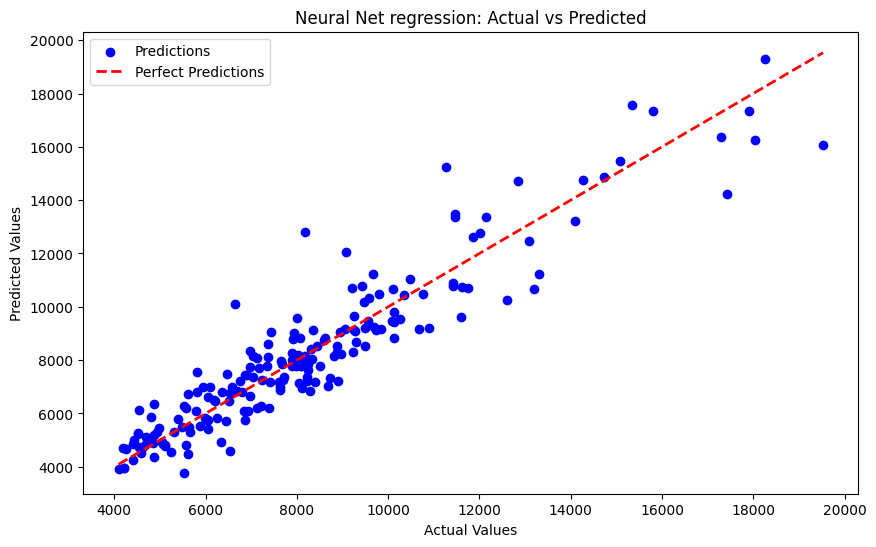

In [ ]:
# Plot the prediction curve
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, predictions_np, color='blue', label='Predictions')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.title('Neural Net regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

**Result:** We observe a minor performance reversion for this model relative to the NN architecture with dropout, such that each sentinel value witnesses a performance decline.
```
Performance of NN Architecture (with dropout)
Epoch [100/200], Loss: 2741536.5000
Epoch [200/200], Loss: 2632704.0000
Mean Absolute Error (MAE): 782.3421
Mean Squared Error (MSE): 1181324.7901
Root Mean Squared Error (RMSE): 1086.8877
R-squared Score: 0.8725
```



# 6. Conclusion

The deep learning NN models exhibit both a slightly lower RMSE and a slightly higher R-squared score relative to the prior approaches; this suggests enhanced performance. It appears that, for this dataset, the deep learning approach offers a modest improvement in predictive performance over the traditional supervised learning (linear regression) methods tested previously.

In this notebook, we expanded the data modelling process to include a subset of confounding variables drawn from official UK government sources in the form of the [English Indices of Deprivation](https://data.london.gov.uk/dataset/indices-of-deprivation). These offer pertinent socio-economic indicators for each sub-borough LSOA geographic scale unit. The confounding variables have improved model performance relative to the simpler bivariate models found in the "Modelling a bivariate relationship" notebook. This is ideal, in that we have expanded the dataset features using real-world indicator data and in doing so, have helped improve model performance from an RMSE perspective.

**Future Directions:** In consideration of future directions for study improvements, we make the following recommendations:
* Introduce more confounding variables to better reflect the dynamism of a complex urban environment
* Expand the time-series from 2017-2019 to a longer temporal extent, and/or
* Broaden the geographic extent of the study

To build on the above, we offer the following caveats and insights:

*Features*: The confounding variables are helpful in improving model performance and interest. After all, there is more at play to housing prices than the prevalence of STR properties in a geographic area. With this in mind, it would be useful to further integrate more confounding variables (such as proximity to transit and amenities, impact of policymaking) into a future iteration of this study.

*Geography:* The expansion of the geographic extent would necessarily require thought and nuance. The current geographic extent of inner London was not selected arbitrarily; this is where approximately 75% of all STR in the region are found and so it is not clear that this would support model development in any meaningful way.

In the third and final modelling notebook, we consider a granular picture of detailed STR data to explore the amenities and characteristics that influence STR pricing.

